## Bike sharing
Let's focus on predicting the number of users based on weather and temporal information
**Outcome (Y)**, choose one:
- Total number of bikers `cnt` *(we chose this one!)*
- Count of casual or registered users (`casual` or `registered`)
- **Bonus**: the difference or ratio between registered and casual
**Models**
    - Model 0 (dummy baseline): Always predict the average of Y in the training data
    - Model 1: Predict based on a linear model with `instant` as the only predictor
    - Model 2: Model including weather info (temperature, windspeed) and temporal parameters (e.g., `season`, `weekday`) as predictors
    - Model 3: A "kitchen sink" model, will all predictors included

The code is copied from Roberta's script called 'Example'.
We want to predict how many bikes are rented each hour (column 'cnt' = count)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


/tmp/ipykernel_3498/1476333803.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
filepath = "../../../../data/class_01/bikes.csv"
data = pd.read_csv(filepath)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [5]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


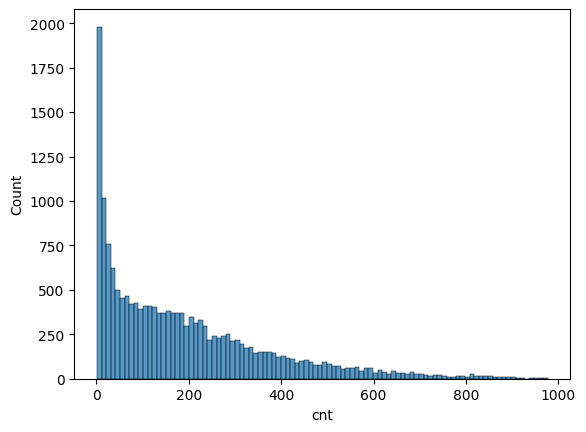

In [6]:
sns.histplot(data=data, x='cnt', binwidth=10)
plt.show()

IndexError: list index out of range

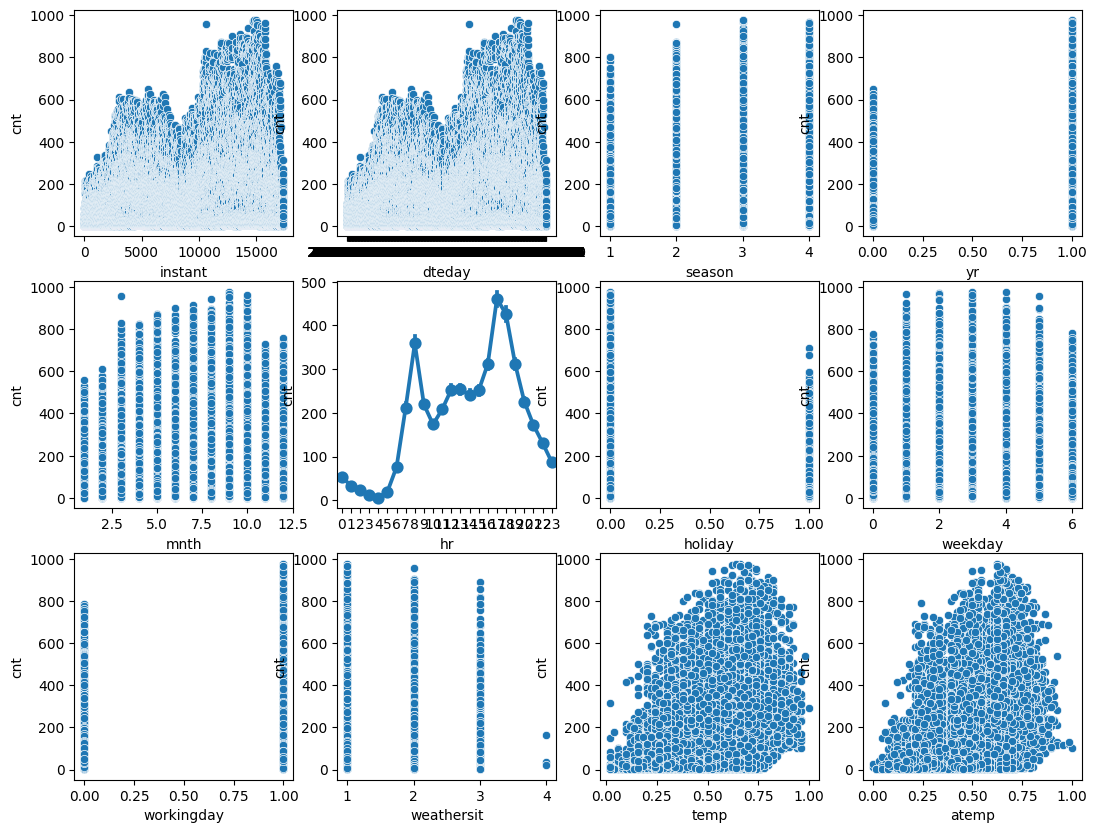

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(13,10))
plot_idx = list(itertools.product(range(3), range(4)))
for i,c in enumerate(data.columns):
    if c != 'cnt':
        if c == 'hr':
            sns.pointplot(data=data, x=c, y='cnt', ax=ax[plot_idx[i]])
        else:
            sns.scatterplot(data=data, x=c, y='cnt', ax=ax[plot_idx[i]])
plt.tight_layout()
plt.show()

In [8]:
X = data.iloc[:,:16].values
y = data.iloc[:,16].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

In [10]:
performances = []

Model 0 (dummy baseline): Always predict the average of Y in the training data

In [11]:
mean_value = y_train.mean()
model_name = 'dummy'
for y,nsplit in zip([y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    performance = np.sqrt(mean_squared_error(y, 
                                             [mean_value]*y.shape[0]))
    r2 = r2_score(y, [mean_value]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [12]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 183.5925, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 174.2015, 'r2': -0.001},
 {'model': 'dummy', 'split': 'test', 'rmse': 178.0718, 'r2': -0.0012}]

Model 1: Predict based on a linear model with instant as the only predictor

In [13]:
instant_col = 0 # it is the first column of the dataframe
reg = LinearRegression().fit(X_train[:,instant_col].reshape(-1,1), y_train)
#pkl.dump(reg, file=open(f'example-models/linear-demographics.pkl', 'wb')) # save the model

In [14]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x[:,instant_col].reshape(-1,1))
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-instant-col',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [15]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 183.5925, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 174.2015, 'r2': -0.001},
 {'model': 'dummy', 'split': 'test', 'rmse': 178.0718, 'r2': -0.0012},
 {'model': 'linear-instant-col',
  'split': 'train',
  'rmse': 175.8159,
  'r2': 0.0829},
 {'model': 'linear-instant-col',
  'split': 'val',
  'rmse': 167.9975,
  'r2': 0.069},
 {'model': 'linear-instant-col',
  'split': 'test',
  'rmse': 172.9454,
  'r2': 0.0556}]

In [16]:
for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train[:,instant_col].reshape(-1,1), y_train)
    #pkl.dump(neigh, file=open(f'example-models/knn-demographics-{k}.pkl','wb')) # save the model
    for x,y,nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
        preds = neigh.predict(x[:,instant_col].reshape(-1,1))
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'knn-instant-{k}',
                            'split': nsplit,
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

Model 2: Model including weather info (temperature, windspeed) and temporal parameters (e.g., season, weekday) as predictors


In [17]:
weather_cols = range(4,14)
reg = LinearRegression().fit(X_train[:,weather_cols], y_train)

In [18]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x[:,weather_cols])
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-weather',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [19]:
for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train[:,weather_cols], y_train)
    #pkl.dump(neigh, file=open(f'example-models/knn-demographics-{k}.pkl','wb')) # save the model
    for x,y,nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
        preds = neigh.predict(x[:,weather_cols])
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'knn-weather-{k}',
                            'split': nsplit,
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

In [20]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 183.5925, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 174.2015, 'r2': -0.001},
 {'model': 'dummy', 'split': 'test', 'rmse': 178.0718, 'r2': -0.0012},
 {'model': 'linear-instant-col',
  'split': 'train',
  'rmse': 175.8159,
  'r2': 0.0829},
 {'model': 'linear-instant-col',
  'split': 'val',
  'rmse': 167.9975,
  'r2': 0.069},
 {'model': 'linear-instant-col',
  'split': 'test',
  'rmse': 172.9454,
  'r2': 0.0556},
 {'model': 'knn-instant-3', 'split': 'train', 'rmse': 63.2229, 'r2': 0.8814},
 {'model': 'knn-instant-3', 'split': 'val', 'rmse': 100.5842, 'r2': 0.6663},
 {'model': 'knn-instant-3', 'split': 'test', 'rmse': 101.2629, 'r2': 0.6762},
 {'model': 'knn-instant-5', 'split': 'train', 'rmse': 90.6531, 'r2': 0.7562},
 {'model': 'knn-instant-5', 'split': 'val', 'rmse': 114.2346, 'r2': 0.5696},
 {'model': 'knn-instant-5', 'split': 'test', 'rmse': 117.1001, 'r2': 0.567},
 {'model': 'knn-instant-10', 'split': 'train', 'rmse': 132.78

Model 3: A "kitchen sink" model, will all predictors included (excluding the specific date column, because that column is causing trouble)

In [21]:
all_cols = range(2,16) # from 2nd to (not including) 16

In [22]:
all_cols = range(2,16) # but doesn't work if you write 17..

reg = LinearRegression().fit(X_train[:,all_cols], y_train) # all columns


In [23]:

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x[:,all_cols])
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-all',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

KNN model

In [24]:
for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train[:,all_cols], y_train)
    #pkl.dump(neigh, file=open(f'example-models/knn-demographics-{k}.pkl','wb')) # save the model
    for x,y,nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
        preds = neigh.predict(x[:,all_cols])
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'knn-all_cols-{k}',
                            'split': nsplit,
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

In [25]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 183.5925, 'r2': 0.0},
 {'model': 'dummy', 'split': 'val', 'rmse': 174.2015, 'r2': -0.001},
 {'model': 'dummy', 'split': 'test', 'rmse': 178.0718, 'r2': -0.0012},
 {'model': 'linear-instant-col',
  'split': 'train',
  'rmse': 175.8159,
  'r2': 0.0829},
 {'model': 'linear-instant-col',
  'split': 'val',
  'rmse': 167.9975,
  'r2': 0.069},
 {'model': 'linear-instant-col',
  'split': 'test',
  'rmse': 172.9454,
  'r2': 0.0556},
 {'model': 'knn-instant-3', 'split': 'train', 'rmse': 63.2229, 'r2': 0.8814},
 {'model': 'knn-instant-3', 'split': 'val', 'rmse': 100.5842, 'r2': 0.6663},
 {'model': 'knn-instant-3', 'split': 'test', 'rmse': 101.2629, 'r2': 0.6762},
 {'model': 'knn-instant-5', 'split': 'train', 'rmse': 90.6531, 'r2': 0.7562},
 {'model': 'knn-instant-5', 'split': 'val', 'rmse': 114.2346, 'r2': 0.5696},
 {'model': 'knn-instant-5', 'split': 'test', 'rmse': 117.1001, 'r2': 0.567},
 {'model': 'knn-instant-10', 'split': 'train', 'rmse': 132.78